# Diabetes dataset demo

In [1]:
!pip install tensorly

     |████████████████████████████████| 112kB 4.8MB/s 
     |████████████████████████████████| 163kB 14.9MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.0-cp36-none-any.whl size=143028 sha256=0cc001637ecbe111b19a7b4ebbba2e2b525b48806a52206d335023c5d426668c
  Stored in directory: /root/.cache/pip/wheels/29/54/bc/46d12f7739ad709844b21801e3a91127bc91002111448e3572
Successfully built tensorly


In [2]:
import torch
import numpy as np
from torch import nn
import tensorly as tl
from tqdm import tqdm
import matplotlib.pyplot
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_

## Tensor layer code

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import tqdm

import tensorly as tl
from tensorly.random import random_tucker
from tensorly.tucker_tensor import tucker_to_tensor


from torch.utils.data import Dataset

#tl.set_backend('pytorch')


class NeuralTensorLayer(torch.nn.Module):
    
    """
    This is the class for the layer
    """
    
    def __init__(self, order, input_dim, output_dim, rank_tucker=-1,
                 initializer=torch.nn.init.xavier_uniform):
        
        super(NeuralTensorLayer, self).__init__()
        
        self.order = order
        self.rank_tucker = rank_tucker
        
        if order > 3 or order < 1:
            raise Exception('Order must be in range [1, 3]')
            
        if rank_tucker != -1 and rank_tucker < 1:
            raise Exception('Tucker rank must be -1 or greater than 0 integer')
            
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.bias = nn.Parameter(torch.zeros((1, output_dim)), requires_grad=True)
        initializer(self.bias)
        
        self.myparameters = torch.nn.ParameterList([self.bias])
        
        self.order1_tens = self.initialize_n_order_tensor(1, initializer)
        
        if order >= 2:
            self.order2_tens = self.initialize_n_order_tensor(2, initializer)
            
        if order == 3:
            self.order3_tens = self.initialize_n_order_tensor(3, initializer)
        
    # initialize tensor in full or in decomposed form and register it as parameter
    def initialize_n_order_tensor(self, order, initializer):
        
        if self.rank_tucker >= 1:
            
            dim_list = [self.input_dim] * order + [self.output_dim]
            tens_core, factors = random_tucker(dim_list, self.rank_tucker)
            tens_core = nn.Parameter(tens_core, requires_grad=True)
            factors = [nn.Parameter(fact, requires_grad=True) for fact in factors]
            
            self.myparameters.append(tens_core)
            for fact in factors:
                self.myparameters.append(fact)
                
            return (tens_core, factors)
            
        else:
            
            dim_list = [self.input_dim] * order + [self.output_dim]
            var = nn.Parameter(torch.zeros(dim_list), requires_grad=True)
            initializer(var)
            self.myparameters.append(var)
            
            return var

    def compute_result_for_vec(self, core, factor_inp, last_factor): # result dim (1, 1)
        result = core
        for i in range(len(factor_inp)):
            result = tl.tenalg.mode_dot(result, factor_inp[i], i)
        result = result.view(1, -1).mm(torch.transpose(last_factor, 0, 1))
        return result.view(-1)

    def mode_n_dot_accelerated(self, core, factors, input):

        new_factors = [torch.transpose(factors[i], 0, 1).mm(input) for i in range(len(factors) - 1)]

        return torch.stack([
                            self.compute_result_for_vec(core, 
                                                        [new_factors[k][:, i] for k in range(len(factors) - 1)], factors[-1]) 
                            for i in range(input.shape[1])
                            ], dim=0)
        
    def forward(self, X, transposed=False):
        
        #X = torch.Tensor(X)
        
        if self.rank_tucker == -1:
            result = torch.addmm(self.bias, X, self.order1_tens)
        else:
            result = torch.addmm(self.bias, X, tucker_to_tensor(self.order1_tens))
        
        if self.order >= 2:
            
            if self.rank_tucker == -1:      
                acc = tl.tenalg.mode_dot(self.order2_tens, X, 0)
            else:
                acc = tl.tenalg.mode_dot(tucker_to_tensor(self.order2_tens), X, 0)

            acc = tl.tenalg.mode_dot(acc, X, 1)
            result += torch.einsum('iik->ik', acc)
        
        if self.order == 3:
             
            if self.rank_tucker == -1:      
                acc = tl.tenalg.mode_dot(self.order3_tens, X, 0)
            else:
                acc = tl.tenalg.mode_dot(tucker_to_tensor(self.order3_tens), X, 0)
            
            acc = tl.tenalg.mode_dot(acc, X, 1)
            acc = tl.tenalg.mode_dot(acc, X, 2)
            result += torch.einsum('iiik->ik', acc)
        
        return tl.reshape(result, (X.shape[0], self.output_dim))

    def get_orthogonality_loss(self):

        if self.rank_tucker == -1:
            return 0

        loss = 0

        for fact in self.order1_tens[1]:
            loss += torch.sum((tl.dot(fact.T, fact) - torch.eye(fact.shape[1]).cuda()) ** 2)
        
        if self.order >= 2:
            
            for fact in self.order2_tens[1]:
                loss += torch.sum((tl.dot(fact.T, fact) - torch.eye(fact.shape[1]).cuda()) ** 2)
        
        if self.order == 3:
             
            for fact in self.order3_tens[1]:
                loss += torch.sum((tl.dot(fact.T, fact) - torch.eye(fact.shape[1]).cuda()) ** 2)

        return loss

## Neural network based on tensor layer

In [71]:
class TensorNet(nn.Module): 
    
    def __init__(
        self, order, input_dim, output_dim, rank_tucker=5
    ):
        super(TensorNet, self).__init__()
        self.tensor = NeuralTensorLayer(
            order, input_dim, output_dim, rank_tucker=rank_tucker
        )
        self.bn = nn.BatchNorm1d(output_dim)
        #self.l = nn.Linear(tensor_dim, output_dim)
        self.s = nn.Sigmoid()
        
    def forward(self, x):
        return(self.s(self.bn(self.tensor(x))))
    
    def predict(self, loader, loss=None, train=True, verbose=False, orth_alpha=None):
        Y_hat = []
        mean_loss = 0
        ld = tqdm(loader) if verbose else loader
        for i,a in enumerate(ld):
            d = a[0] if train else a
            c_Y_hat = self.forward(d)
            c_y_hat = c_Y_hat.cpu().data.numpy()
            Y_hat.append(c_y_hat)
            if train:
                loss_val = loss(c_Y_hat, a[1])
                if orth_alpha:
                    loss_val += self.tensor.get_orthogonality_loss()*orth_alpha
                mean_loss += loss_val.cpu().data.numpy()
        return np.concatenate(Y_hat), mean_loss / i
    
    def fit(
        self, loader, loss, optimizer, scheduler, n_iter, 
        val_loader, metrics, print_every=10, orth_alpha=0.1, fit_orthogonality=True
    ):
        history = {a: [] for a in metrics}
        history["train_loss"] = []
        history["val_loss"] = []
        for j in tqdm(np.arange(n_iter)):
            mean_loss = 0
            self.train()
            for i,(batch_X, batch_Y) in enumerate(loader):
                optimizer.zero_grad()
                Y_hat = self.forward(batch_X)
                loss_val = loss(Y_hat, batch_Y)
                if fit_orthogonality:
                    loss_val += self.tensor.get_orthogonality_loss()*orth_alpha
                loss_val.backward()
                optimizer.step()
                mean_loss += loss_val.cpu().data.numpy()
            history["train_loss"].append(mean_loss/i)
            self.eval()
            val_Y_hat, val_loss = self.predict(val_loader, loss, orth_alpha=orth_alpha)
            history["val_loss"].append(val_loss)
            val_Y = np.concatenate([a[1].cpu().data.numpy() for a in val_loader])
            for m in metrics:
                history[m].append(metrics[m](val_Y, val_Y_hat))
            if (j+1) % print_every == 0:
                print("epoch#"+str(j))
                print("train loss", history["train_loss"][-1])
                print("val loss", history["val_loss"][-1])
                for m in metrics:
                    print(m, history[m][-1])
            clip_grad_norm_(self.parameters(), 0.3)
            scheduler.step()
        return history

## Data import

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
tl.set_backend('pytorch')

In [89]:
data_dir = '/content/drive/My Drive/study/Skoltech/MTF/Project/data/'

In [90]:
BATCH_SIZE = 32

In [91]:
import pandas as pd
data = pd.read_csv(data_dir + 'diabetes.csv').sample(frac=1).reset_index()
data.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,203,2,99,70,16,44,20.4,0.235,27,0
1,497,2,81,72,15,76,30.1,0.547,25,0
2,601,6,96,0,0,0,23.7,0.190,28,0
3,400,4,95,64,0,0,32.0,0.161,31,1
4,582,12,121,78,17,0,26.5,0.259,62,0


In [92]:
len(data)

768

In [93]:
target = np.matrix(data['Outcome']).T
input = np.matrix(data.drop('Outcome', axis=1))

train_input = torch.from_numpy(input[:-100]).type(torch.FloatTensor).cuda()
train_target = torch.from_numpy(target[:-100]).type(torch.FloatTensor).cuda()

test_input = torch.from_numpy(input[-100:]).type(torch.FloatTensor).cuda()
test_target = torch.from_numpy(target[-100:]).type(torch.FloatTensor).cuda()

In [94]:
train_dataset = torch.utils.data.TensorDataset(train_input, train_target)
test_dataset = torch.utils.data.TensorDataset(test_input, test_target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model initialisation

In [101]:
NN = TensorNet(3, input.shape[1], target.shape[1], 15).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [102]:
loss = nn.BCELoss()
optimizer = Adam(NN.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

In [103]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

def balanced_accuracy(Y, Y_hat):
    Y_hat[Y_hat > 0.5] = 1
    Y_hat[Y_hat <= 0.5] = 0
    return balanced_accuracy_score(Y, Y_hat)

## Training procedure

In [104]:
hist = NN.fit(train_loader, loss, optimizer, scheduler, 200, test_loader, {'balanced_accuracy': balanced_accuracy, 'ROC-AUC': roc_auc_score})

epoch#9
train loss 220.55479278564454
val loss 263.86891682942706
balanced_accuracy 0.6314338235294117
ROC-AUC 0.6314338235294118
epoch#19
train loss 93.3558391571045
val loss 114.11863199869792
balanced_accuracy 0.6047794117647058
ROC-AUC 0.604779411764706
epoch#29
train loss 53.672199440002444
val loss 66.41472880045573
balanced_accuracy 0.5790441176470589
ROC-AUC 0.5790441176470589
epoch#39
train loss 36.990587425231936
val loss 46.09224319458008
balanced_accuracy 0.5560661764705883
ROC-AUC 0.5560661764705882
epoch#49
train loss 28.544528007507324
val loss 35.69538688659668
balanced_accuracy 0.6654411764705883
ROC-AUC 0.6654411764705883
epoch#59
train loss 23.70262727737427
val loss 29.71533139546712
balanced_accuracy 0.6893382352941176
ROC-AUC 0.6893382352941176
epoch#69
train loss 20.674644184112548
val loss 25.95618502298991
balanced_accuracy 0.6654411764705883
ROC-AUC 0.6654411764705883
epoch#79
train loss 18.655515003204346
val loss 23.438289006551106
balanced_accuracy 0.704963

## Results visualisation

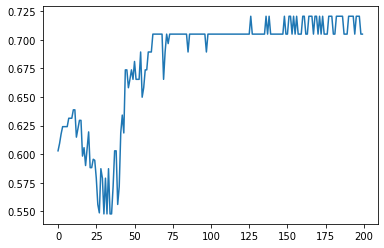

In [105]:
plt.plot(np.arange(len(hist['balanced_accuracy'])), hist['balanced_accuracy'])

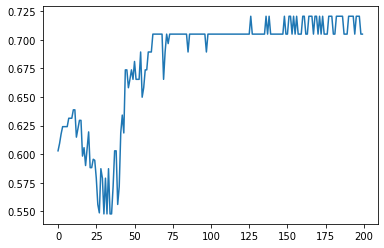

In [106]:
plt.plot(np.arange(len(hist['ROC-AUC'])), hist['ROC-AUC'])